## CLM-PPE LAI test -PFT calibration
#### Updated August 29, 2023

- Test PFT LAI emulator performance
  - Variable: Annual max LAI averaged by pft (2003-2014)
  - Error: (model-obs)/obs within 1%
  - Observational target: CLM-SP PFT-LAI

- Evaluation ensemble 
  - 25 universal parameter sets (randomly selected from NROY space)
  - For each universal set, one PFT parameter set randomly selected for each pft

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from esem import gp_model
from esem.utils import get_random_params, leave_one_out, prediction_within_ci
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import gpflow

2023-08-30 12:25:09.708015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 12:25:10.139325: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-30 12:25:10.285560: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-30 12:25:12.851769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") ; sys.path.append("../pyth/")
from ppe_analysis.analysis import *
from pyfunctions import *
from emulation_pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [4]:
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.64:37148,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load original CLM-PPE

In [57]:
PPE_lai = xr.open_dataset('./processed_data/LHC_pmean(TLAImax).nc')
PPE_lai = PPE_lai['TLAI_pftavg_annMax_2003-2014']

In [26]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][0:17]

### Load new ensemble members

In [6]:
# load LHC LAI 
# LH move experiment to daniels campaign directory
ds_new_h1=get_exp('pftLAI',dvs=['TLAI'],tape='h1',yy=(2003,2014))

t=slice(str(2003),str(2014))
da_new = ds_new_h1.TLAI.sel(time=t)

In [7]:
amax_lai=amax(da_new).mean(dim='year').compute()

In [41]:
PPE_lai_new = xr.open_dataset('./processed_data/pftLAI_pmean(TLAImax).nc')
PPE_lai_new = PPE_lai_new['TLAI_pftavg_annMax_2003-2014']

### Load Observational data

In [9]:
#calculate SP LAI, by pft
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('../clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

lai_sp=amax(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai_sp,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

### Plot distributions

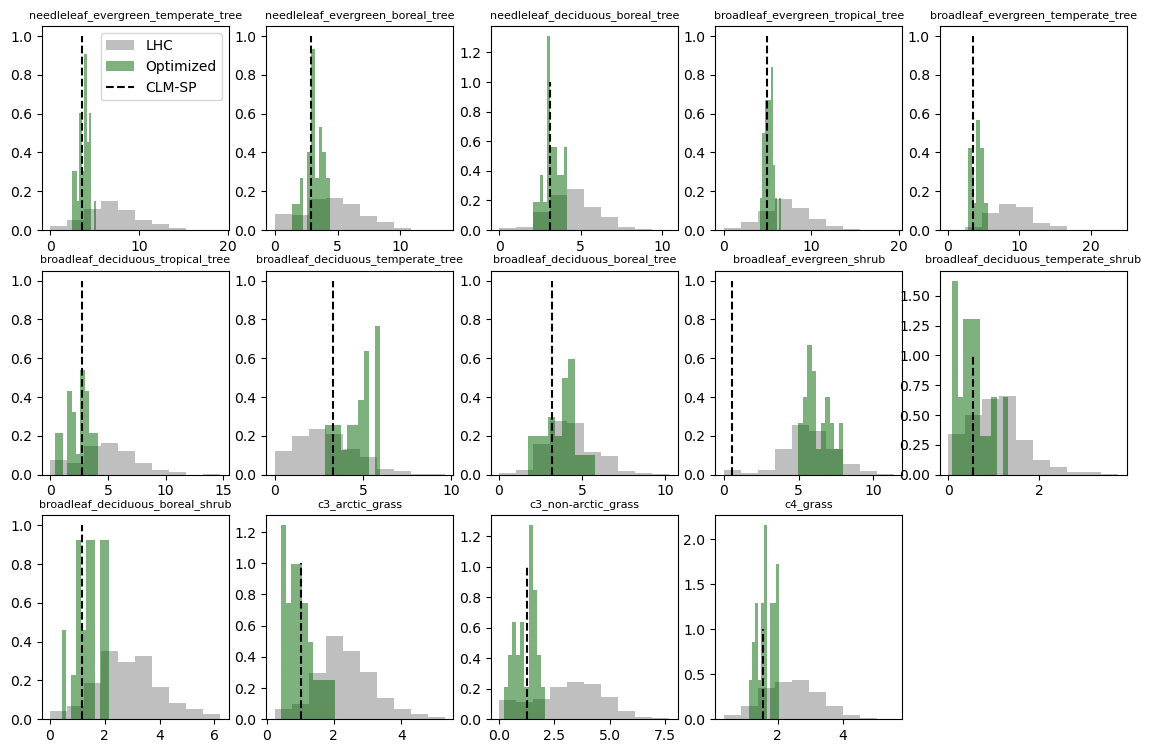

In [83]:
plt.figure(figsize=[14,9])
plt.rcParams.update({'font.size': 10})

for p in range(1,15):
    plt.subplot(3,5,p)

    plt.hist(PPE_lai.isel(pft=p),color='grey',alpha=0.5,label='LHC',density=True)
    plt.hist(PPE_lai_new.isel(pft=p),alpha=0.5,color='darkgreen',label='Optimized',density=True)
    
    plt.plot([laisp[p],laisp[p]],[0,1],'k--',label='CLM-SP')

    plt.title(pfts[p],fontsize=8)
    if p ==1:
        plt.legend()
plt.savefig('./figs/pftLAI_distribution.png',dpi=300)

### Map bias

In [36]:
# load CLM-PPE h0
dvs=['TLAI']
htape='h0'
yr0=2003
yr1=2014
ds_h0=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [37]:
t=slice(str(2003),str(2014))
lhc_sets_h0 = amax(ds_h0.TLAI.sel(time=t)).mean(dim='year').compute()

In [39]:
# load experiment H0
ds_new_h0=get_exp('pftLAI',dvs=['TLAI'],tape='h0',yy=(2003,2014))

t=slice(str(2003),str(2014))
exp_sets_h0 = amax(ds_new_h0.TLAI.sel(time=t)).mean(dim='year').compute()

In [67]:
LHC_map_def = get_map(lhc_sets_h0[0])

In [50]:
# SP map
dsp_h0=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h0.2000-02-01-00000.nc')
dsp_h0['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
# need to load h0 version of lai_sp or learn how to get_map of PFTs...
#SP_map = get_map(lai_sp)
SP_map_h0 = amax(dsp_h0.TLAI).mean(dim='year').compute()

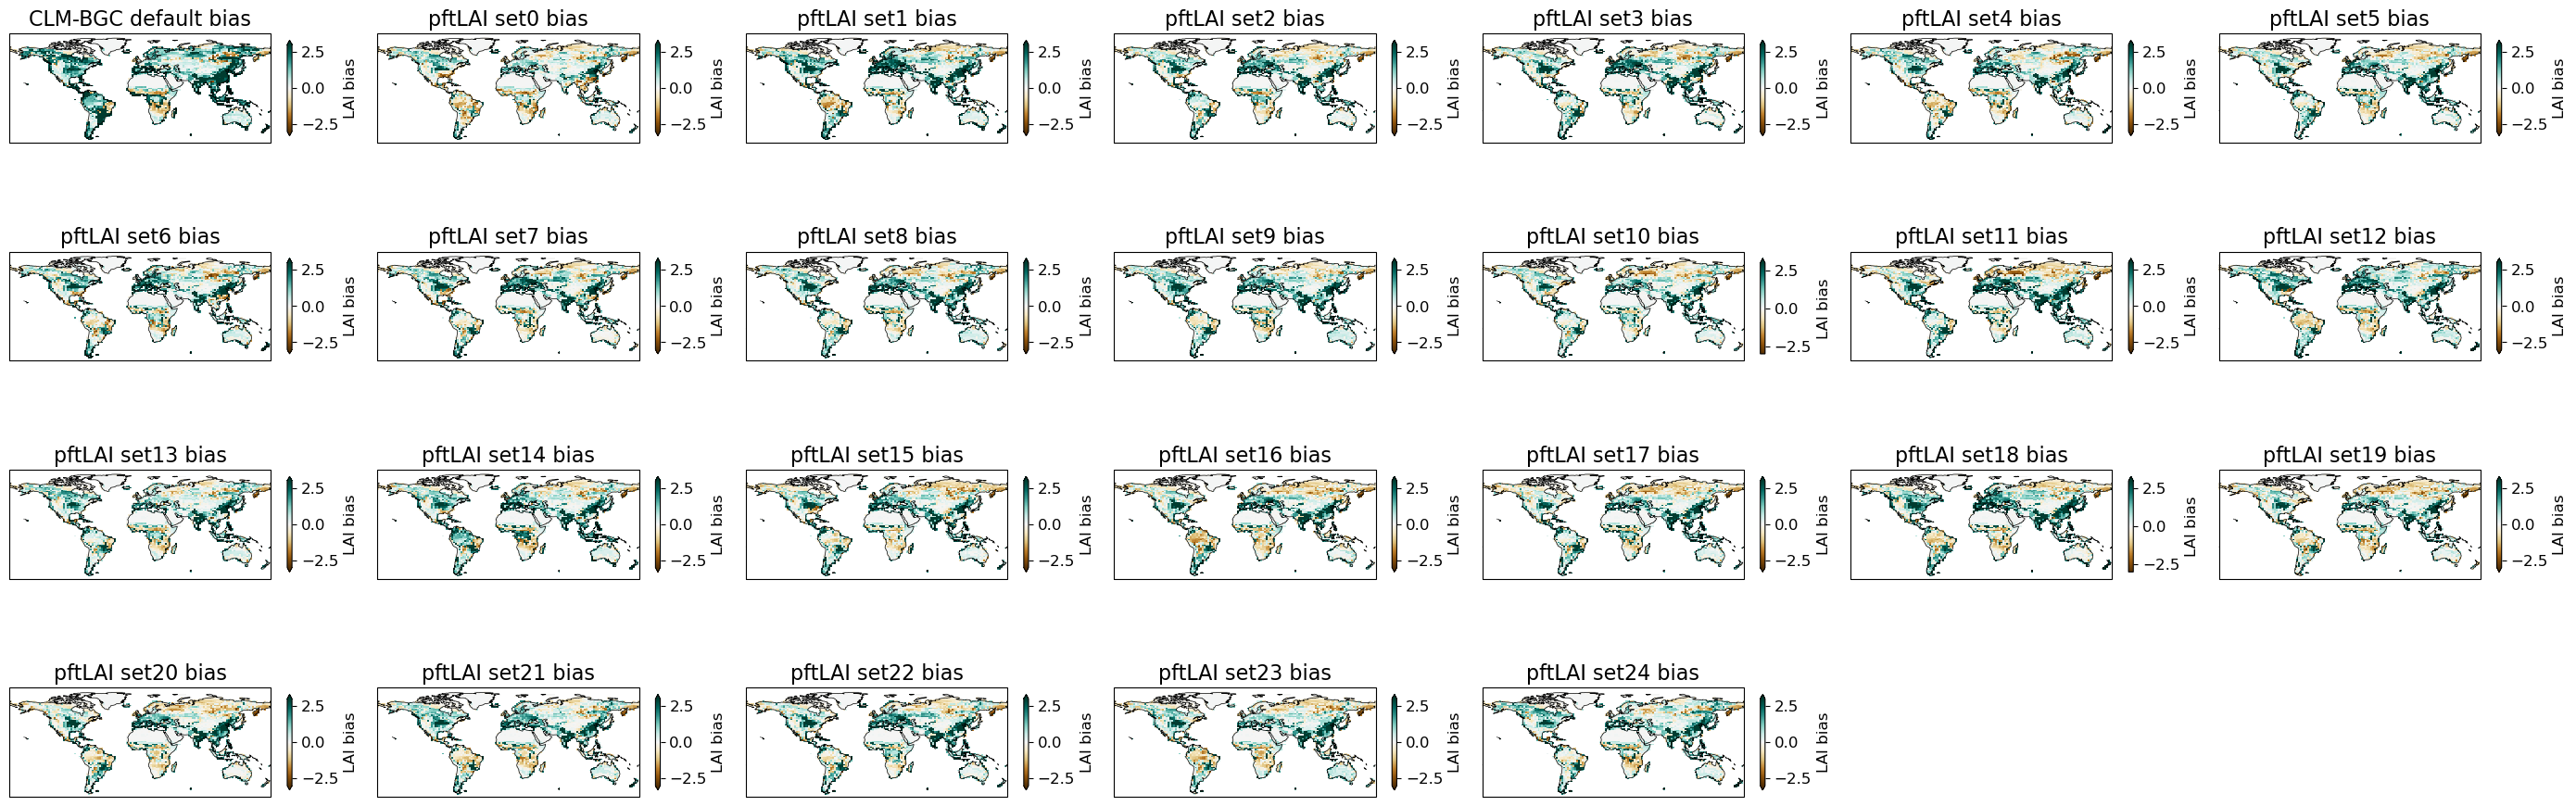

In [77]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

obs = SP_map_h0
# 0, 4, 5
# map
crs = ccrs.PlateCarree()
plt.figure(figsize=[28,10])
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0, hspace=0)
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(4,7,1,projection=crs)
LHC_bias = LHC_map_def - obs
LHC_bias.plot(ax=ax,cmap = 'BrBG',vmin = -3,vmax=3,cbar_kwargs={'label':'LAI bias','shrink': 0.4})
ax.coastlines("110m", color="k",linewidth = .5)
plt.ylim([-60,90])
plt.title('CLM-BGC default bias',fontsize=16)

for s in range(25):
    EXP_map = get_map(exp_sets_h0[s])
    ax = plt.subplot(4,7,s+2,projection=crs)
    LHC_bias = EXP_map - obs
    LHC_bias.plot(ax=ax,cmap = 'BrBG',vmin = -3,vmax=3,cbar_kwargs={'label':'LAI bias','shrink': 0.4})
    ax.coastlines("110m", color="k",linewidth = .5)
    plt.ylim([-60,90])
    plt.title('pftLAI set'+str(s)+' bias',fontsize=16)
         
plt.tight_layout()
plt.savefig('./figs/pftLAI_bias_map_SP_LAImax.png',dpi=300)

#### Plot by PFT

In [154]:
# get SP
htape='h1'
SP_pft = get_SP(htape)
SP_LAI = amax(SP_pft).mean(dim='year')

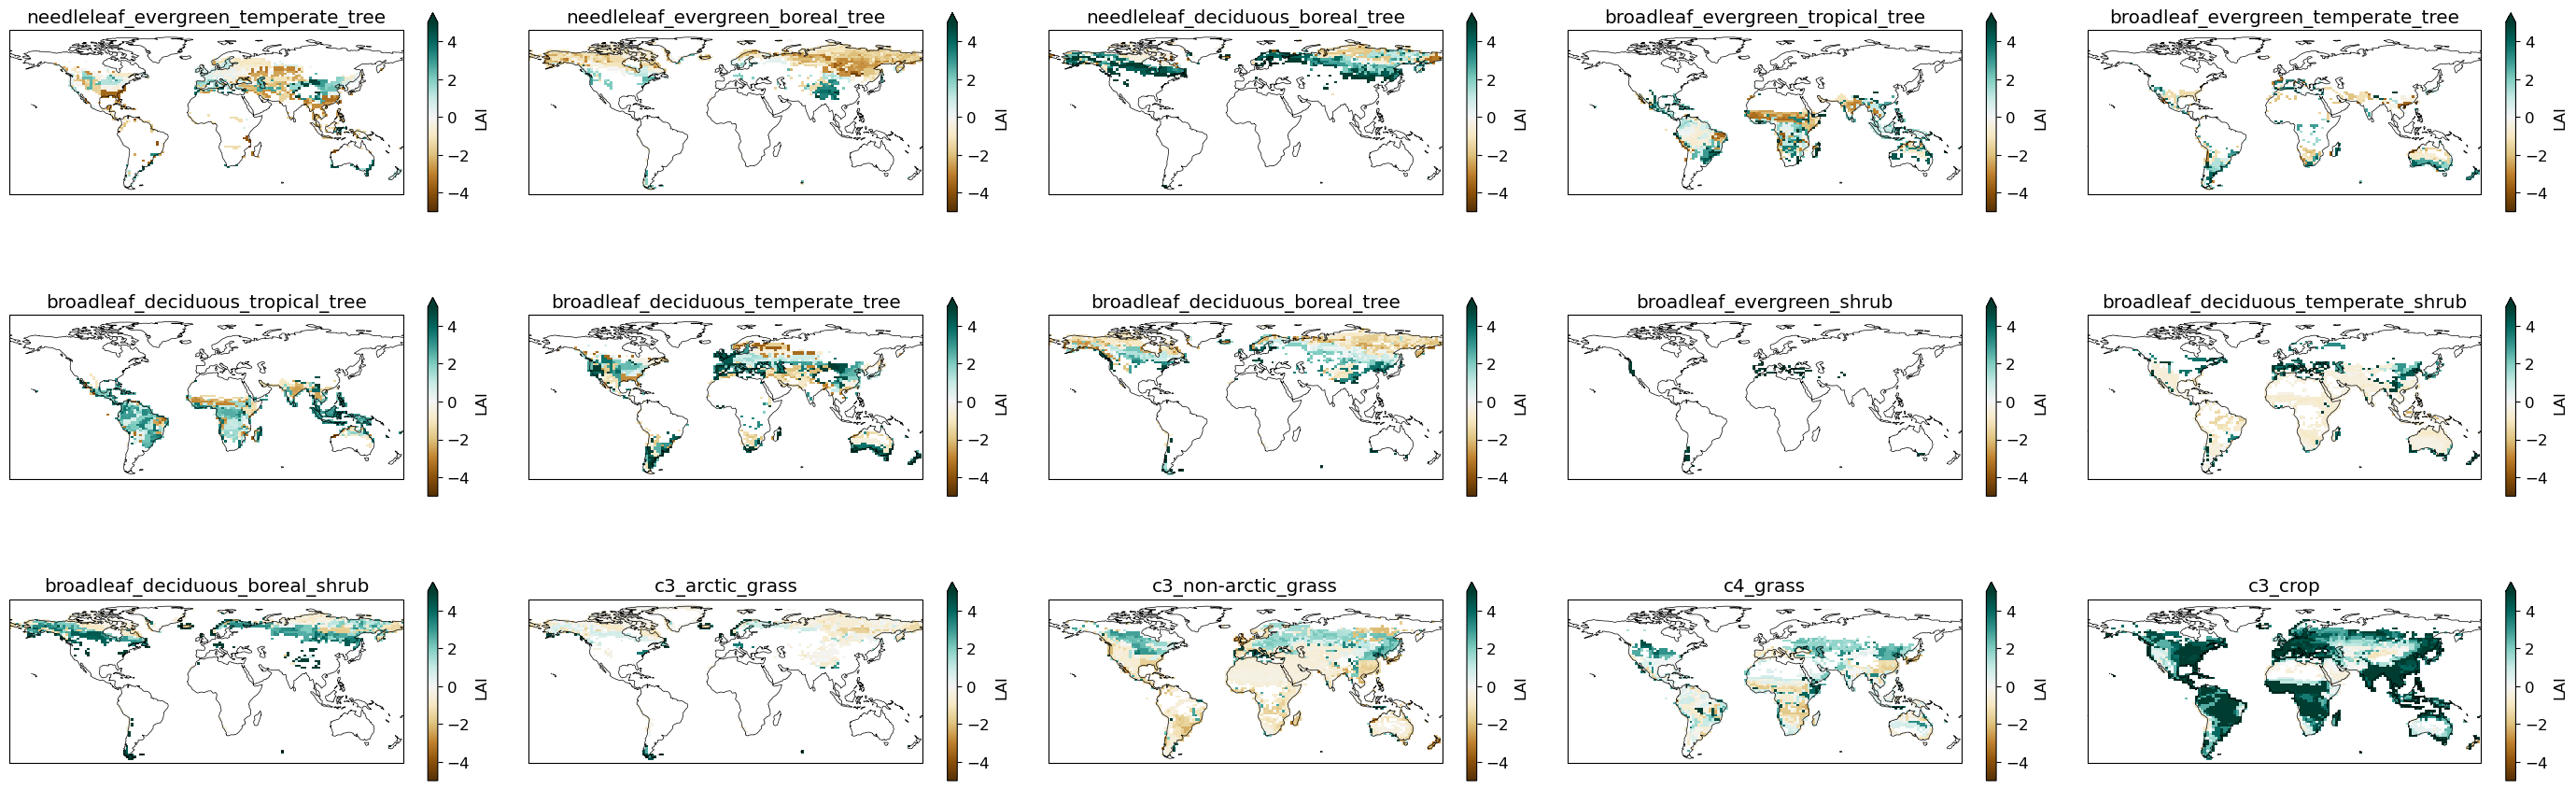

In [193]:
crs = ccrs.PlateCarree()
plt.figure(figsize=[28,10])
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0, hspace=0)
plt.rcParams.update({'font.size': 12})

in_data = amax_lai.sel(ens=3)
#in_data = lai_amax.sel(ens=0)
for p in range(1,16):
    ax = plt.subplot(3,5,p,projection=crs)
    map0 = get_pft_map(in_data,p)
    SP_map = get_pft_map(SP_LAI,p,SP=True)
    diff_map = map0-SP_map
    #diff_map.plot(ax=ax,center=0,cbar_kwargs={"label": "LAI",'shrink': 0.6})
    diff_map.plot(ax=ax,vmin = -5,vmax=5,cmap = 'BrBG',cbar_kwargs={"label": "LAI",'shrink': 0.6})
    ax.coastlines("110m", color="k",linewidth = .5)
    plt.ylim([-60,90])
    plt.title(pfts[p])
plt.tight_layout()
plt.savefig('./figs/PFT_SPbias_ens3.png',dpi=100)

### Evaluate Emulators

In [10]:
u_params     = ['FUN_fracfixers','KCN','a_fix','crit_dayl','d_max','fff','fstor2tran','grperc',
                'jmaxb0','jmaxb1','kcha','lmrha','lmrhd','nstem','q10_mr','soilpsi_off','sucsat_sf',
                'tpu25ratio','tpuse_sf','wc2wjb0']
pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']

In [11]:
top_sets = np.load('pftLAI_psets_8-25.npy',allow_pickle=True).item()

In [12]:
# restructure pft paramsets
top_sets_r = np.empty((25,32,16))*np.NaN

for pft in range(1,15):
    for u in range(25):
        a=[] ; b=[]
        for i,up in enumerate(u_params):
            a.append(top_sets[up][u])
        for i,pp in enumerate(pft_params):
            b.append(top_sets[pp][u][pft])
        top_sets_r[u,:,pft] = np.hstack([a,b])

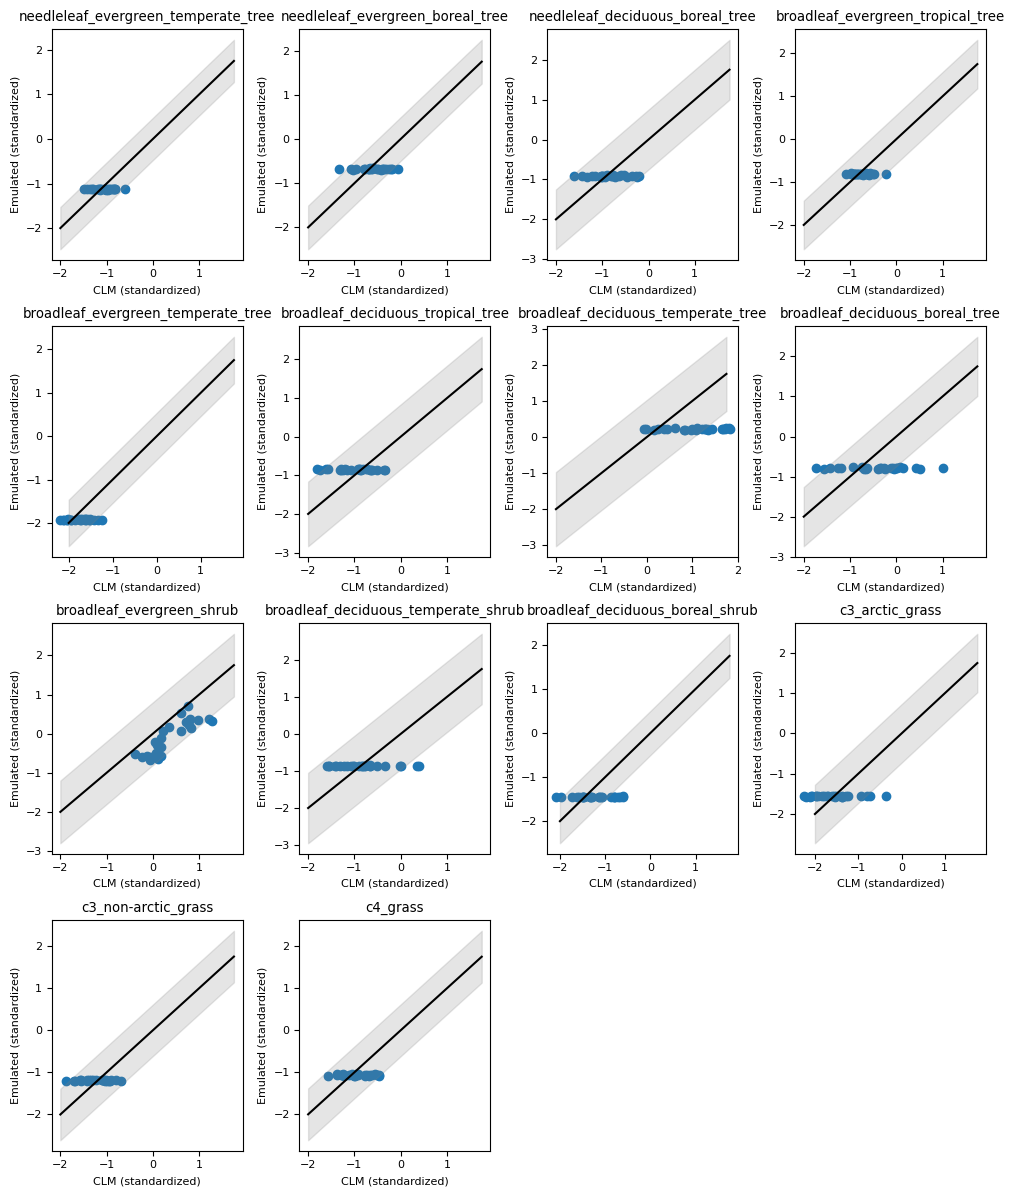

In [80]:
# Evaluate emulator performance (in standardized space)
plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 8})

x = np.arange(-2,2,0.25)
y = np.arange(-2,2,0.25)

for p in range(1,15):
    s = top_sets_r[:,:,p]
    loaded_emulator = tf.saved_model.load('./models/'+pfts[p]+'/')
    y_pred, y_pred_var = loaded_emulator.compiled_predict_y(s)
    y_pred_std = np.max(y_pred_var)**0.5
    
    clm = (PPE_lai_new.isel(pft=p).values - PPE_lai.isel(pft=p).mean().values)/PPE_lai.isel(pft=p).std().values

    ax = plt.subplot(4,4,p)
    ax.scatter(clm,y_pred)
    ax.fill_between(x, y-2*y_pred_std, y+2*y_pred_std,alpha = 0.2,color='grey')
    ax.plot(x,y,'k')
    plt.title(pfts[p])
    plt.xlabel('CLM (standardized)')
    plt.ylabel('Emulated (standardized)')

plt.tight_layout()
plt.savefig('./figs/pftLAI_emulator_evaluation_standardized_2SD.png',dpi=100)